In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

In [14]:
from sklearn.cluster import KMeans

def split_by_kmeans(cnt, binary, k=2):
    # 1. 创建轮廓区域 mask
    mask = np.zeros_like(binary)
    cv2.drawContours(mask, [cnt], -1, 255, -1)

    # 2. 获取 mask 内部所有像素点坐标 (y,x)
    ys, xs = np.where(mask == 255)
    coords = np.column_stack((xs, ys))

    # 3. 如果点太少或太密，跳过
    if len(coords) < 50:
        return [cnt]

    # 4. KMeans 聚类
    kmeans = KMeans(n_clusters=k, n_init=10).fit(coords)
    labels = kmeans.labels_

    # 5. 按聚类结果生成mask
    split_contours = []
    for i in range(k):
        cluster_mask = np.zeros_like(binary)
        cluster_points = coords[labels == i]
        for x, y in cluster_points:
            cluster_mask[y, x] = 255
        cluster_mask = cv2.morphologyEx(cluster_mask, cv2.MORPH_CLOSE, np.ones((3,3),np.uint8))
        # 提取轮廓
        contours, _ = cv2.findContours(cluster_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        split_contours.extend(contours)

    return split_contours

def is_overlapping(cnt, solidity_thresh=1.15, defect_thresh=2, print_info=False, return_data = False):
    area = cv2.contourArea(cnt)
    hull = cv2.convexHull(cnt)
    hull_area = cv2.contourArea(hull)
    solidity = hull_area  / area if area > 0 else 1.0

    # hull_indices = cv2.convexHull(cnt, returnPoints=False)
    # defects = cv2.convexityDefects(cnt, hull_indices)
    # num_defects = len(defects) if defects is not None else 0
    if print_info:
        print(f"Area: {area}, Solidity: {solidity}, Ratio: {area/hull_area}")
    
    if return_data:
        return solidity > solidity_thresh, hull_area  / area
    else:
        return solidity > solidity_thresh #or num_defects >= defect_thresh


def cut_by_deepest_defects(cnt, binary, top_k=2, depth_thresh=1000):
    hull = cv2.convexHull(cnt, returnPoints=False)
    defects = cv2.convexityDefects(cnt, hull)

    # 创建当前轮廓的 mask
    mask = np.zeros_like(binary)
    cv2.drawContours(mask, [cnt], -1, 255, -1)

    if defects is not None and len(defects) >= top_k:
        # 提取所有凹陷点和深度
        far_points = []
        for i in range(defects.shape[0]):
            s, e, f, d = defects[i, 0]
            if d > depth_thresh:
                far = tuple(cnt[f][0])
                far_points.append((far, d))

        # 如果足够多凹陷点，则选择最深的两个
        if len(far_points) >= 2:
            far_points = sorted(far_points, key=lambda x: -x[1])[:top_k]
            pt1, pt2 = far_points[0][0], far_points[1][0]
            cv2.line(mask, pt1, pt2, 0, 2)

    return mask


def recursive_watershed(cnt, binary, img, max_depth=2, current_depth=0, contrast_factor=0.3):
    """
    递归分水岭分割
    :param cnt: 当前处理的轮廓
    :param binary: 二值图像
    :param img: 原始图像
    :param max_depth: 最大递归深度
    :param current_depth: 当前递归深度
    :param contrast_factor: 分水岭对比度因子
    :return: 分割后的轮廓列表
    """
    # 终止条件1: 达到最大递归深度
    if current_depth >= max_depth:
        return [cnt]
    
    # 终止条件2: 轮廓不再需要分割
    if not is_overlapping(cnt):
        return [cnt]
    
    # 执行分水岭分割
    mask = np.zeros_like(binary)
    cv2.drawContours(mask, [cnt], -1, 255, -1)
    roi = cv2.bitwise_and(binary, binary, mask=mask)
    
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(roi, cv2.MORPH_OPEN, kernel, iterations=2)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, contrast_factor * dist_transform.max(), 255, 0)
    
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    _, markers = cv2.connectedComponents(sure_fg)
    markers += 1
    markers[unknown == 255] = 0
    
    img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    markers = cv2.watershed(img_color, markers)
    
    # 收集分割结果并递归处理
    result_contours = []
    for mark in np.unique(markers):
        if mark <= 1:
            continue
        mask2 = np.uint8(markers == mark)
        contours_ws, _ = cv2.findContours(mask2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for sub_cnt in contours_ws:
            # 递归处理子轮廓
            result_contours.extend(
                recursive_watershed(
                    sub_cnt, binary, img, 
                    max_depth, current_depth + 1, 
                    contrast_factor
                )
            )
    
    return result_contours

## watershed only, but multiple times

(-0.5, 1135.5, 499.5, -0.5)

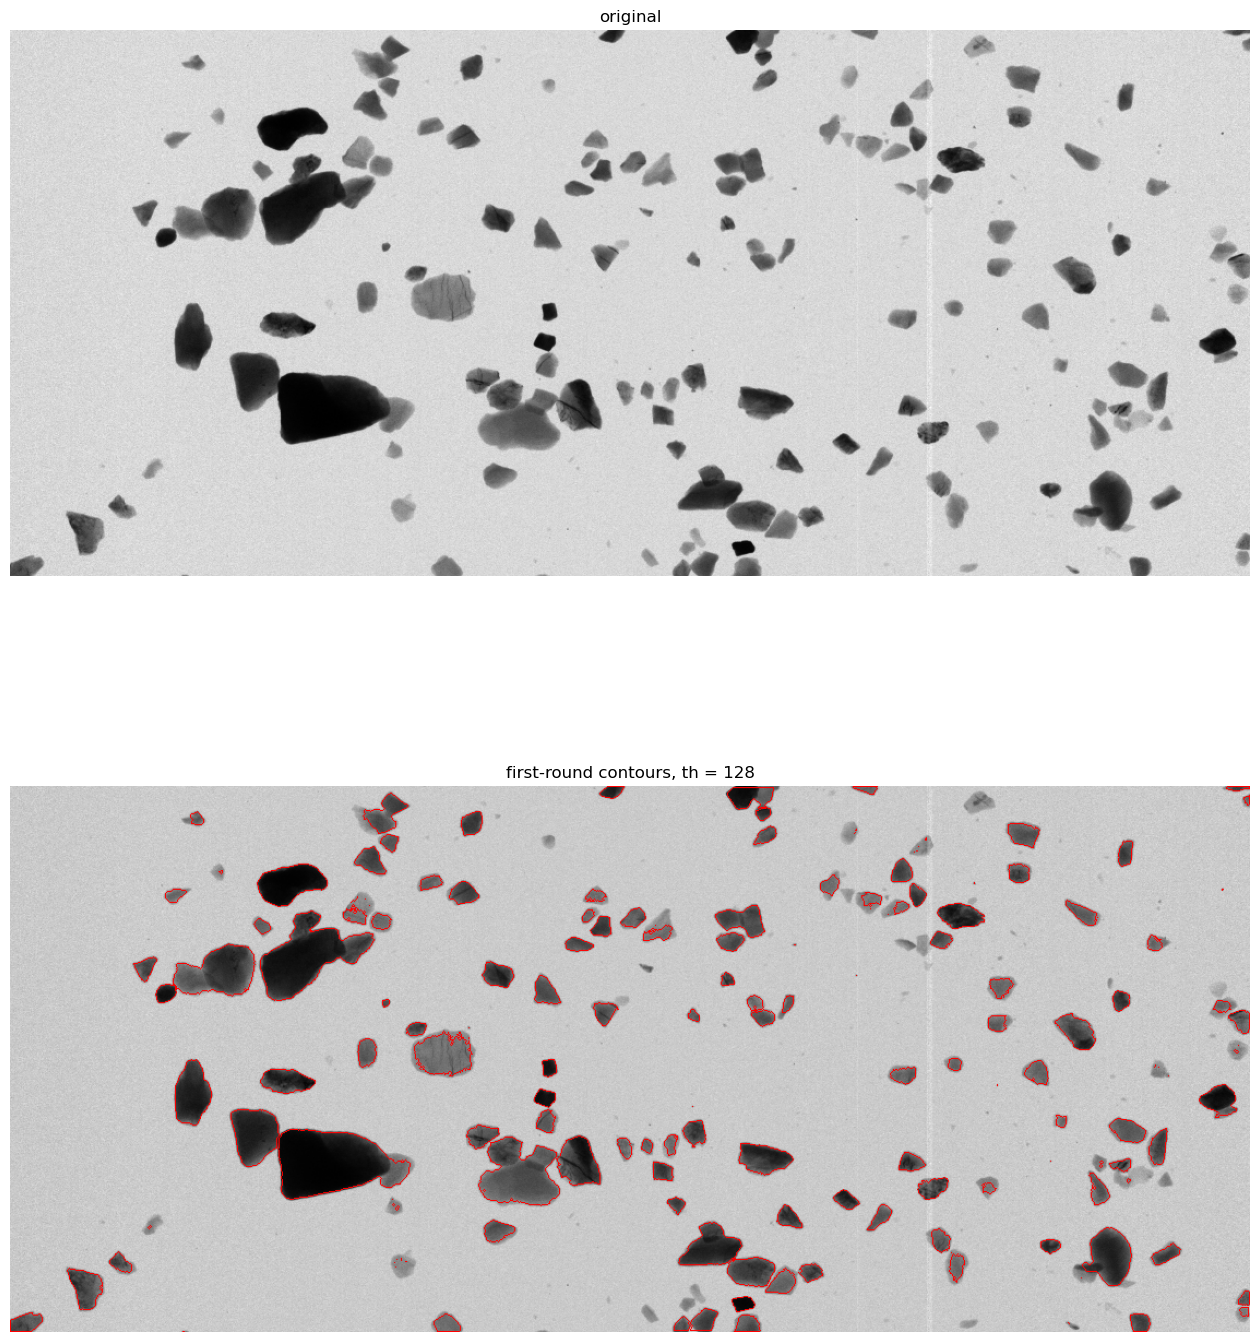

In [17]:
# img = cv2.imread("1749001387562020400.png", cv2.IMREAD_GRAYSCALE)[:, 200:1336]
# img = cv2.imread("1749114607646606900.png", cv2.IMREAD_GRAYSCALE)[:, 200:1336]
# img = cv2.imread("1749114607376323400.png", cv2.IMREAD_GRAYSCALE)[:, 200:1336]
# img = cv2.imread("1749114604927843500.png", cv2.IMREAD_GRAYSCALE)[:, 200:1336]
img = cv2.imread("/Users/zhengyun/Desktop/yaojian/data/test_data_yinshan/test_one_image/1749114605350494900.png", 
                 cv2.IMREAD_GRAYSCALE)[:, 200:1336]
# th_binary, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
_, binary = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV); th_binary = 128

# 构造新分割 mask
final_mask_v2 = np.zeros_like(binary)

contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

normal_contours = []
split_contours = []

error_contours = []
cnt_needs = []
for cnt in contours:
    if is_overlapping(cnt, solidity_thresh=1.15):
        split_contours.extend(recursive_watershed(cnt, binary, img, max_depth=2))
    else:
        normal_contours.append(cnt)


all_contours = split_contours + normal_contours
# 绘制结果
result = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
cv2.drawContours(result, all_contours, -1, (255, 0, 0), 1)


# 显示新结果
fig, axes = plt.subplots(2, 1, figsize=(16, 18))
# # axes[1].imshow(output_v2)
# axes[2].set_title("deepest_defects")
# axes[2].axis('off')
# axes[2].imshow(mask_only2)

axes[0].imshow(img, cmap = 'gray')
axes[0].set_title("original")
axes[0].axis('off')

axes[1].imshow(result, cmap = 'gray')
axes[1].set_title("first-round contours, th = %s"%th_binary)
axes[1].axis('off')



## defects only

(-0.5, 1135.5, 499.5, -0.5)

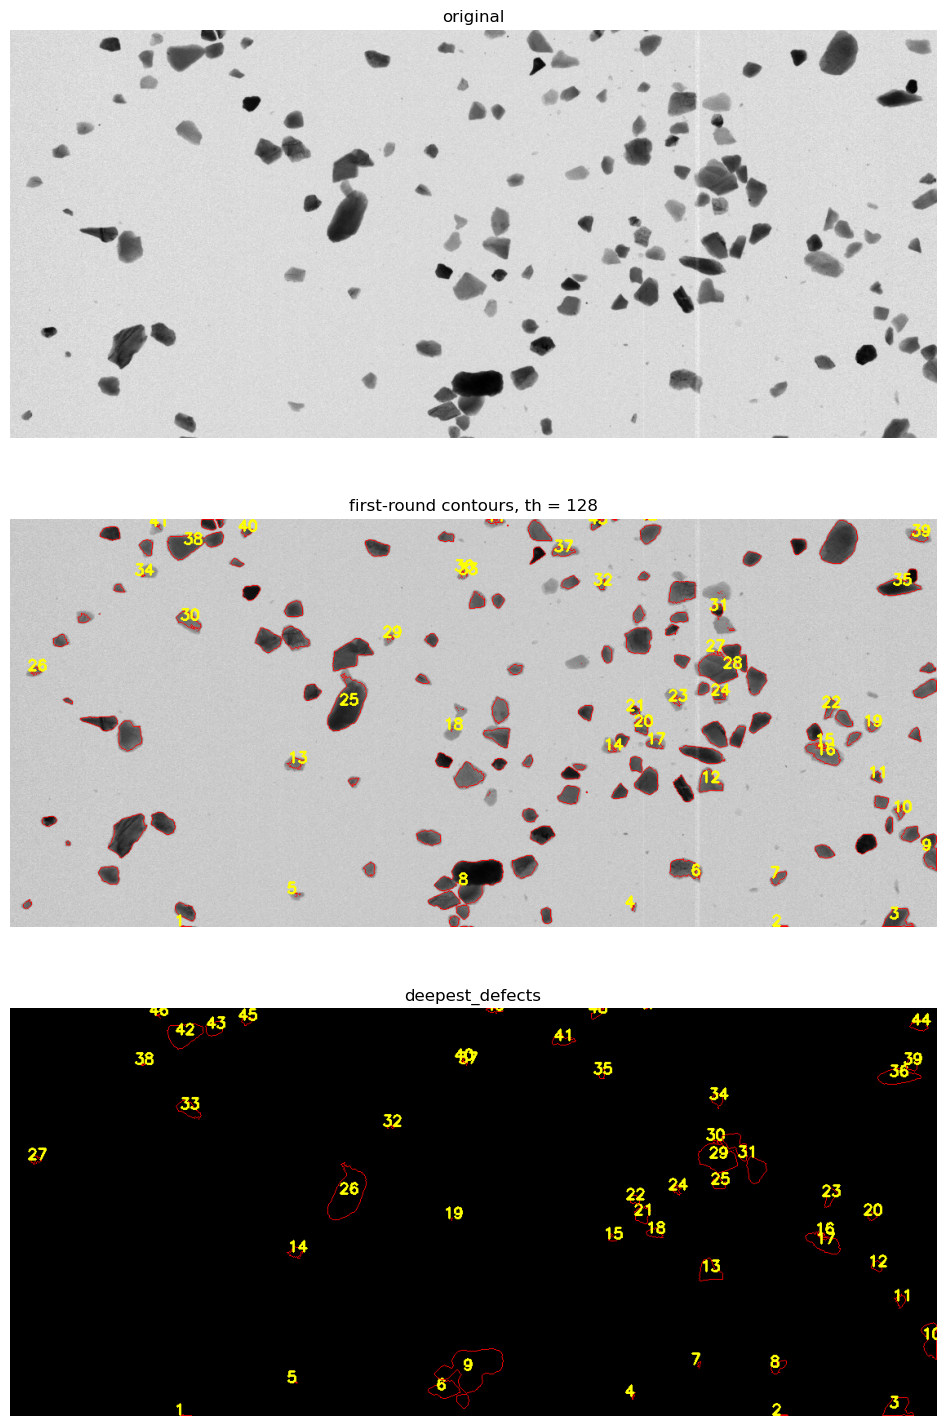

In [7]:
# img = cv2.imread("1749001387562020400.png", cv2.IMREAD_GRAYSCALE)[:, 200:1336]
# img = cv2.imread("1749114607646606900.png", cv2.IMREAD_GRAYSCALE)[:, 200:1336]
# img = cv2.imread("1749114607376323400.png", cv2.IMREAD_GRAYSCALE)[:, 200:1336]
img = cv2.imread("1749114604927843500.png", cv2.IMREAD_GRAYSCALE)[:, 200:1336]

# th_binary, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
_, binary = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV); th_binary = 128

# 构造新分割 mask
final_mask_v2 = np.zeros_like(binary)

contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

normal_contours = []
split_contours = []

error_contours = []
cnt_needs = []
for cnt in contours:
    if is_overlapping(cnt, solidity_thresh=1.15):
        cnt_needs.append(cnt)
        # 选择每个轮廓中最深的两个凹陷点，并连线切割
        try:
            cut_mask = cut_by_deepest_defects(cnt, binary)
            final_mask_v2 = cv2.bitwise_or(final_mask_v2, cut_mask)
        except:
            error_contours.append(cnt)

    # if is_overlapping(cnt):
    #     # 用聚类算法替代分水岭
    #     sub_contours = split_by_kmeans(cnt, binary, k=2)  # 也可以自动调k
    #     split_contours.extend(sub_contours)


# 提取新轮廓
contours_v2, _ = cv2.findContours(final_mask_v2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 绘制结果
result = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
cv2.drawContours(result, contours, -1, (255, 0, 0), 1)

output_v2 = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
mask_only2 = np.zeros_like(result)
for i, cnt in enumerate(contours_v2):
    cv2.drawContours(output_v2, [cnt], -1, (255, 0, 0), 2)
    cv2.drawContours(mask_only2, [cnt], -1, (255, 0, 0), 1)
    M = cv2.moments(cnt)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        cv2.putText(mask_only2, f"{i+1}", (cx - 10, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)


for i, cnt in enumerate(cnt_needs):
    M = cv2.moments(cnt)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        cv2.putText(result, f"{i+1}", (cx - 10, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

# 显示新结果
fig, axes = plt.subplots(3, 1, figsize=(16, 18))
# axes[1].imshow(output_v2)
axes[2].set_title("deepest_defects")
axes[2].axis('off')
axes[2].imshow(mask_only2)

axes[0].imshow(img, cmap = 'gray')
axes[0].set_title("original")
axes[0].axis('off')

axes[1].imshow(result, cmap = 'gray')
axes[1].set_title("first-round contours, th = %s"%th_binary)
axes[1].axis('off')



In [11]:
hull = cv2.convexHull(cnt, returnPoints = False)

In [12]:
hull

array([[21],
       [17],
       [16],
       [13],
       [12],
       [ 7],
       [ 5],
       [ 2],
       [ 1],
       [ 0]], dtype=int32)

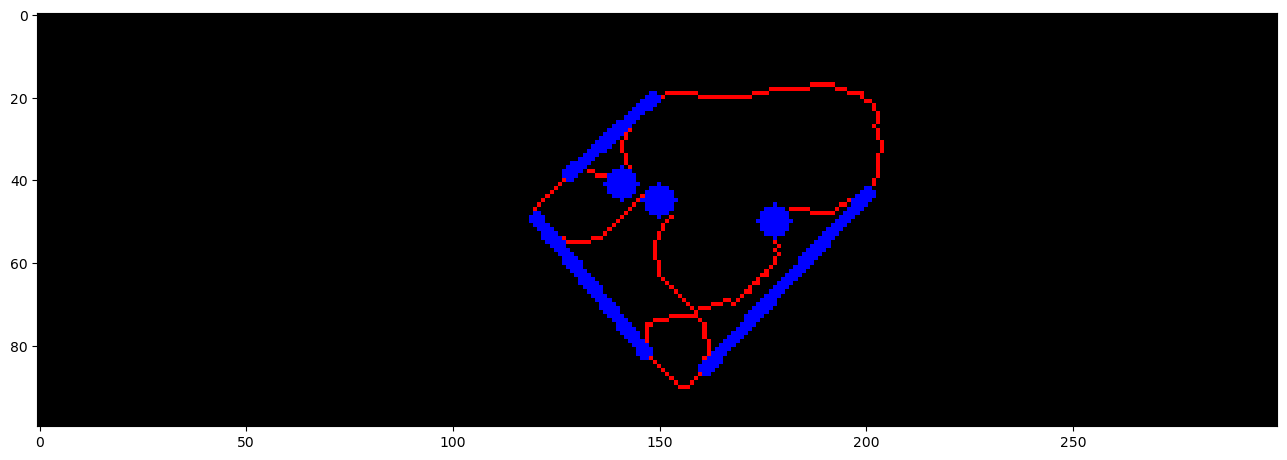

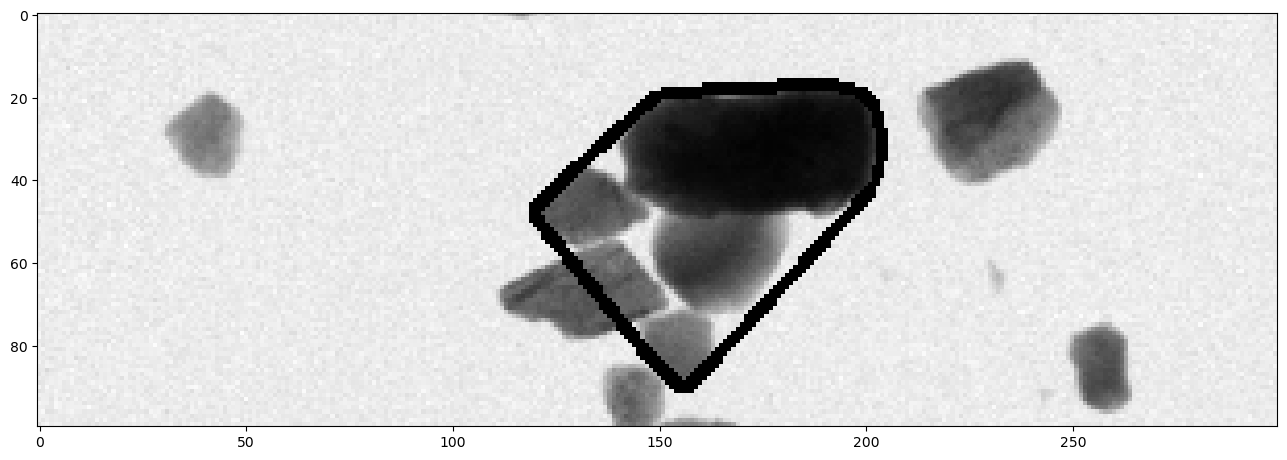

In [292]:

mask_needs = np.zeros_like(result)
cv2.drawContours(mask_needs, [contours_v2[9]], -1, (255, 0, 0), thickness=1)
defects = draw_defect_lines(contours_v2[9], mask_needs)
plt.figure(figsize = (16, 8))
plt.imshow(mask_needs[400:, 400: 700], cmap="gray")

plt.figure(figsize = (16, 8))
test = img.copy()
for cntt in [contours_v2[9]]:
    hull = cv2.convexHull(cntt)
    # 绘制凸包
    cv2.drawContours(test, [hull], 0, (0,255,0), 2)
    plt.imshow(test[400:, 400: 700], cmap='gray')

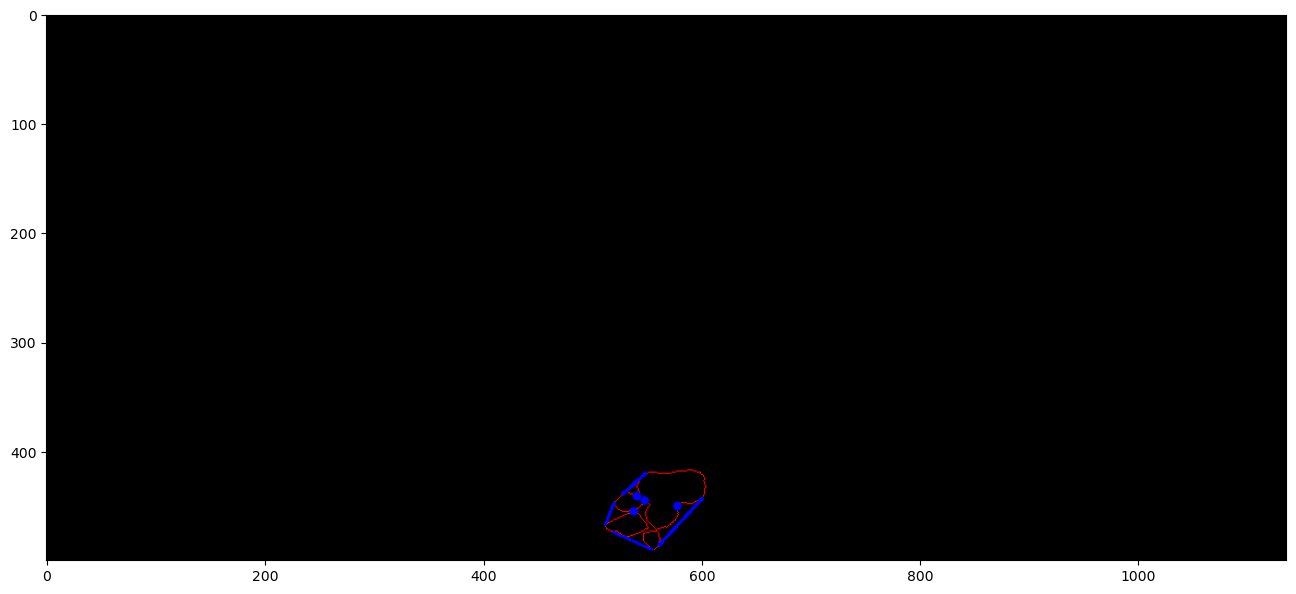

In [289]:
def draw_defect_lines(cnt, img_draw):
    hull = cv2.convexHull(cnt, returnPoints=False)
    defects = cv2.convexityDefects(cnt, hull)
    if defects is not None:
        for i in range(defects.shape[0]):
            s, e, f, d = defects[i, 0]
            start = tuple(cnt[s][0])
            end = tuple(cnt[e][0])
            far = tuple(cnt[f][0])
            if d > 1000:  # 深度阈值过滤
                cv2.line(img_draw, start, end, (0, 0, 255), 2)
                cv2.circle(img_draw, far, 4, (0, 0, 255), -1)
    return defects

mask_needs = np.zeros_like(result)
cv2.drawContours(mask_needs, [cnt_needs[8]], -1, (255, 0, 0), thickness=1)
defects = draw_defect_lines(cnt_needs[8], mask_needs)
plt.figure(figsize = (16, 8))
plt.imshow(mask_needs, cmap="gray")

# mask_needs = np.zeros_like(result)
# cv2.drawContours(mask_needs, [cnt_needs[6]], -1, (255), thickness=2)
# plt.figure(figsize = (16, 8))
# plt.imshow(mask_needs, cmap="gray")


## combine watershed with defects

In [376]:
a = [1, 2, 3, 4, 5]
indices = [1, 3]  # 要删除的索引列表
for i in sorted(indices, reverse=True):
    del a[i]

In [ ]:
def recursive_cut_contours(contours, binary, b_thresh, max_depth=3, current_depth=1, all_contours=None):
    """
    递归切割轮廓，保留所有处理过的轮廓
    """
    if all_contours is None:
        all_contours = []
    
    if current_depth > max_depth:
        return all_contours + contours
    
    current_mask = np.zeros_like(binary)
    new_contours = []
    
    for cnt in contours:
        if is_overlapping(cnt, solidity_thresh=b_thresh, print_info=False):
            try:
                cut_mask = cut_by_deepest_defects(cnt, binary)
                contours_cut, _ = cv2.findContours(cut_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                new_contours.extend(contours_cut)
            except:
                continue
        else:
            all_contours.append(cnt)
    
    if new_contours:
        return recursive_cut_contours(new_contours, binary, b_thresh, max_depth, current_depth+1, all_contours)
    else:
        return all_contours + contours
    
def recursive_cut_contours_v2(contours, binary, b_thresh, max_depth=3, current_depth=1, all_contours=None):
    """
    递归切割轮廓，每次只处理上一次新生成的轮廓
    """
    if all_contours is None:
        all_contours = []
    
    if current_depth > max_depth:
        return all_contours + contours
    
    new_contours = []  # 只保存本次新生成的轮廓
    
    for cnt in contours:
        if is_overlapping(cnt, solidity_thresh=b_thresh, print_info=False):
            try:
                cut_mask = cut_by_deepest_defects(cnt, binary)
                contours_cut, _ = cv2.findContours(cut_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                new_contours.extend(contours_cut)
            except:
                all_contours.append(cnt)  # 处理失败的轮廓也加入最终结果
        else:
            all_contours.append(cnt)  # 不重叠的轮廓直接加入最终结果
    
    if new_contours:  # 只传递新生成的轮廓给下一次递归
        return recursive_cut_contours(new_contours, binary, b_thresh, max_depth, current_depth+1, all_contours)
    else:
        return all_contours + contours

In [434]:
def watershed_defects(image_path, a_thresh = 1.15, b_thresh = 1.1, max_depth = 1, solidities = None):
    '''
    solidities: list
    '''

    plt.ioff()
    image_folder = os.path.dirname(image_path)
    base_name = os.path.basename(image_path)  # 获取文件名
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)[:, 200:1336]
    # _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    _, binary = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV)

    # 构造新分割 mask
    final_mask_v2 = np.zeros_like(binary)

    contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    normal_contours = []
    split_contours = []

    error_contours = []

    contrast_factor = 0.3
    for cnt in contours:

        if cv2.contourArea(cnt) > 100:

            if solidities is None:
                overlap = is_overlapping(cnt, solidity_thresh=a_thresh, return_data=False)

            else:
                overlap, solidity = is_overlapping(cnt, solidity_thresh=a_thresh, return_data=True)
                solidities.append(solidity)


                if solidity > a_thresh:


                    test = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
                    hull = cv2.convexHull(cnt)
                    cv2.drawContours(test, [hull], -1, (0, 255, 255), 1) 
                    cv2.drawContours(test, [cnt], -1, (0, 0, 255), 1) 

                    # 创建矿石ROI
                    x,y,w,h = cv2.boundingRect(cnt)
                    ore_roi = test[y:y+h, x:x+w]
                    
                    # 创建标注图像
                    # marked_img = cv2.cvtColor(ore_roi, cv2.COLOR_GRAY2BGR)
                    # cv2.putText(marked_img, f"{solidity:.2f}", 
                    #           (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 
                    #           0.7, (0, 255, 0), 2)
                    
                    # 保存图片

                    save_path = os.path.join(image_folder, 'high_solidity', 
                                          f"s_{solidity:.2f}_{base_name}")
                    os.makedirs(os.path.dirname(save_path), exist_ok=True)
                    cv2.imwrite(save_path, ore_roi)

                continue
        
            if overlap:
                # print(';a;')
                # 构造局部mask
                mask = np.zeros_like(binary)
                cv2.drawContours(mask, [cnt], -1, 255, -1)

                # 在mask区域中做分水岭
                roi = cv2.bitwise_and(binary, binary, mask=mask)
                kernel = np.ones((3, 3), np.uint8)
                opening = cv2.morphologyEx(roi, cv2.MORPH_OPEN, kernel, iterations=2) # 先腐蚀后膨胀
                sure_bg = cv2.dilate(opening, kernel, iterations=3)
                dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
                _, sure_fg = cv2.threshold(dist_transform, contrast_factor * dist_transform.max(), 255, 0)

                sure_fg = np.uint8(sure_fg)
                unknown = cv2.subtract(sure_bg, sure_fg)
                _, markers = cv2.connectedComponents(sure_fg)
                markers += 1
                markers[unknown == 255] = 0

                # Watershed 分割
                img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
                markers = cv2.watershed(img_color, markers)

                for mark in np.unique(markers):
                    if mark <= 1:
                        continue
                    mask2 = np.uint8(markers == mark)
                    contours_ws, _ = cv2.findContours(mask2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                    split_contours.extend(contours_ws)

            # if is_overlapping(cnt):
            #     # 用聚类算法替代分水岭
            #     sub_contours = split_by_kmeans(cnt, binary, k=2)
            #     split_contours.extend(sub_contours)
            else:
                normal_contours.append(cnt)

    
    if solidities is not None:
        return 0

    result = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    mask_only = np.zeros_like(result)
    cv2.drawContours(mask_only, normal_contours, -1, (0, 255, 0), 1)
    cv2.drawContours(mask_only, split_contours, -1, (255, 0, 0), 1)

    # cv2.drawContours(result, normal_contours, -1, (0, 255, 0), 2)
    # cv2.drawContours(result, split_contours, -1, (255, 0, 0), 2)

    # for i, cnt in enumerate(split_contours):
    #     cv2.drawContours(mask_only, [cnt], -1, (255, 255, 0), 1)
    #     # 计算质心
    #     M = cv2.moments(cnt)
    #     if M["m00"] != 0:
    #         cX = int(M["m10"] / M["m00"])
    #         cY = int(M["m01"] / M["m00"])
    #         # 添加序号
    #         cv2.putText(mask_only, str(i), (cX, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1)


    fig, axes = plt.subplots(3, 1, figsize=(16, 18))
    # axes[0].imshow(result)
    axes[1].set_title("watershed")
    axes[1].axis('off')
    axes[1].imshow(mask_only)


    # # 对于分水岭仍未分开的情况，选择每个轮廓中最深的两个凹陷点，并连线切割
    # j_indices = []
    # for j, cnt_i in enumerate(split_contours):
    #     if is_overlapping(cnt_i, solidity_thresh=b_thresh, print_info=False):
    #         try:
    #             cut_mask = cut_by_deepest_defects(cnt_i, binary)
    #             final_mask_v2 = cv2.bitwise_or(final_mask_v2, cut_mask)
    #             j_indices.append(j)
    #         except:
    #             error_contours.append(cnt_i)

    # all_contours = normal_contours + split_contours
    # # 提取新轮廓
    # contours_v2, _ = cv2.findContours(final_mask_v2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    split_contours_processed = recursive_cut_contours_v2(split_contours, binary, b_thresh, max_depth=max_depth)
    all_contours = normal_contours + split_contours_processed

    # output_v2 = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    mask_only2 = np.zeros_like(result)
    for i, cnt in enumerate(split_contours_processed): #contours_v2
        # cv2.drawContours(output_v2, [cnt], -1, (255, 0, 0), 2)
        cv2.drawContours(mask_only2, [cnt], -1, (255, 255, 0), 1)
        # M = cv2.moments(cnt)
        # if M["m00"] != 0:
        #     cx = int(M["m10"] / M["m00"])
        #     cy = int(M["m01"] / M["m00"])
        #     cv2.putText(output_v2, f"{i+1}", (cx - 10, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    # 显示新结果
    # axes[1].imshow(output_v2)
    axes[2].set_title("deepest_defects")
    axes[2].axis('off')
    axes[2].imshow(mask_only2)

    img_ori = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(img_ori, contours, -1, (255, 0, 0), 1)
    axes[0].imshow(img_ori, cmap = 'gray')
    axes[0].set_title("original")
    axes[0].axis('off')

    b_thresh_str = str(b_thresh).replace('.', 'p')  # 将小数点替换为p
    output_path = os.path.join(image_folder, 'contours', f"processed_{base_name}_{b_thresh_str}_{max_depth}.png")
    plt.savefig(output_path, bbox_inches='tight', dpi=300)
    plt.close()

In [ ]:
image_folder = '/Users/zhengyun/Desktop/yaojian/data/test_data_yinshan'
image_paths = glob.glob(f"{image_folder}/*.png") 
for image_path in image_paths:
    # img = cv2.imread("1749001387562020400.png", cv2.IMREAD_GRAYSCALE)[:, 200:1336]
    # img = cv2.imread("1749114607646606900.png", cv2.IMREAD_GRAYSCALE)[:, 200:1336]
    # img = cv2.imread("1749114607376323400.png", cv2.IMREAD_GRAYSCALE)[:, 200:1336]
    # img = cv2.imread("1749114604927843500.png", cv2.IMREAD_GRAYSCALE)[:, 200:1336]
    
    watershed_defects(image_path, b_thresh = 1.1, max_depth=2, solidities = None)

In [ ]:
# image_path = '/Users/zhengyun/Desktop/yaojian/data/test_data_yinshan/1749114605755555900.png'
image_path = '/Users/zhengyun/Desktop/yaojian/data/test_data_yinshan/1749114605350494900.png'
watershed_defects(image_path, b_thresh = 1.1, max_depth=1)

### solidity distribution

In [435]:
image_folder = '/Users/zhengyun/Desktop/yaojian/data/test_data_yinshan'
image_paths = glob.glob(f"{image_folder}/*.png") 
solidities = []
for image_path in image_paths:
    watershed_defects(image_path, a_thresh = 1.1, b_thresh = 1.1, max_depth=2, solidities = solidities)

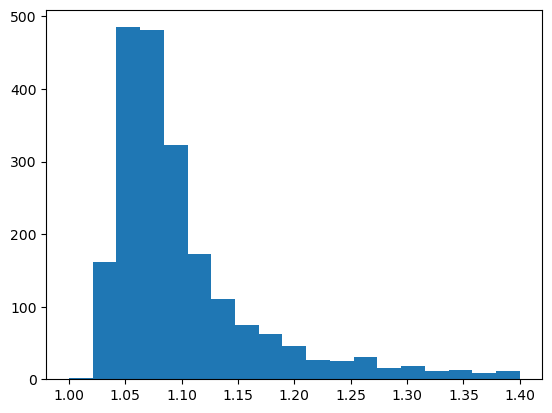

In [409]:
plt.hist(solidities, bins = np.linspace(1, 1.4, 20))
plt.show()

In [408]:
np.arange(1, 1.4, 20)

array([1.])

In [341]:
mask_after = np.zeros_like(result)
cv2.drawContours(mask_after, [split_contours[6]], -1, (255, 0, 0), thickness=1)
# defects = draw_defect_lines(cnt_needs[8], mask_needs)
# plt.figure(figsize = (16, 8))
# plt.imshow(mask_after, cmap="gray")

for i in range(2, 6):
    is_overlapping(split_contours[i], solidity_thresh=0.9, print_info=True)

Area: 976.0, Solidity: 0.8557650153441473, Ratio: 0.8557650153441473
Area: 394.0, Solidity: 0.89749430523918, Ratio: 0.89749430523918
Area: 148.5, Solidity: 0.8583815028901735, Ratio: 0.8583815028901735
Area: 495.5, Solidity: 0.7797010228166797, Ratio: 0.7797010228166797


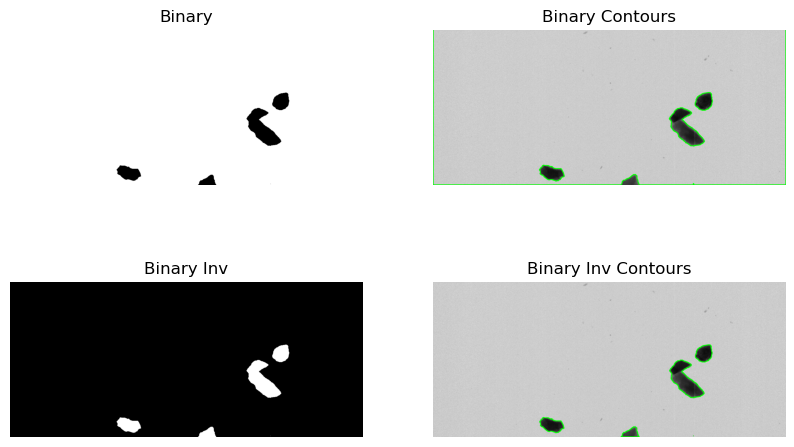

In [160]:
img = cv2.imread("1749001387562020400.png", cv2.IMREAD_GRAYSCALE)[:, 200:1336]

# _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
_, binary_inv = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV)
_, binary = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)

# 构造新分割 mask
final_mask_v2 = np.zeros_like(binary)

contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours_inv, _ = cv2.findContours(binary_inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

result = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
cv2.drawContours(result, contours, -1, (0, 255, 0), 2)

result_inv = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
cv2.drawContours(result_inv, contours_inv, -1, (0, 255, 0), 2)

fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes[0, 0].imshow(binary, cmap = 'gray')
axes[0, 0].set_title('Binary')
axes[0, 1].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
axes[0, 1].set_title('Binary Contours')
axes[1, 0].imshow(binary_inv, cmap = 'gray')
axes[1, 0].set_title('Binary Inv')
axes[1, 1].imshow(cv2.cvtColor(result_inv, cv2.COLOR_BGR2RGB))
axes[1, 1].set_title('Binary Inv Contours')
# for ax in axes.ravel():
#     ax.set_xticks([])
#     ax.set_yticks([])
for i in range(2):
    for j in range(2):
        axes[i, j].axis('off')

# for cnt in contours:
#     area = cv2.contourArea(cnt)




In [57]:
hull = cv2.convexHull(contours[2], returnPoints=False)
defects = cv2.convexityDefects(contours[2], hull)

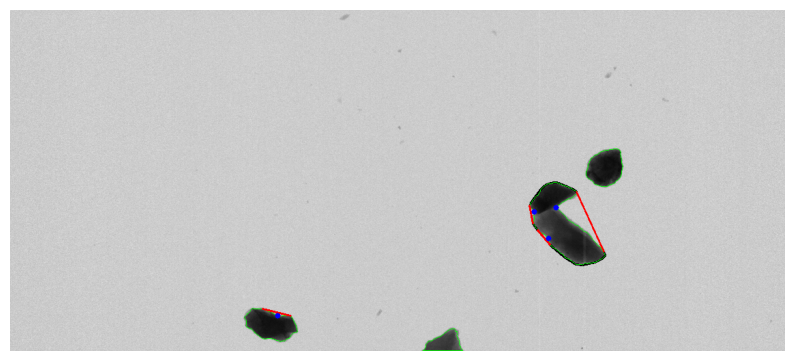

In [ ]:
# 创建绘图底图
result = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
# 遍历所有轮廓，分析并绘制凹陷切割线
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > 1000:
        cv2.drawContours(result, [cnt], -1, (0, 255, 0), 1)
        draw_defect_lines(cnt, result)

# 显示结果
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
# plt.title("轮廓及凹陷分割线演示")
plt.axis('off')
plt.show()
